In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(42)

from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier

from sklearn.metrics import accuracy_score, f1_score, confusion_matrix


In [5]:
lfw = fetch_lfw_people(min_faces_per_person=50, resize=0.4)

X = lfw.data
y = lfw.target
target_names = lfw.target_names

print("Dimensions X :", X.shape)
print("Nombre de classes :", len(target_names))

Dimensions X : (1560, 1850)
Nombre de classes : 12


In [6]:
## Exploration rapide des données

#J’analyse les dimensions du dataset, la distribution des classes
#et la présence éventuelle de valeurs manquantes.

In [7]:
unique, counts = np.unique(y, return_counts=True)

df_dist = pd.DataFrame({
    "Classe": target_names,
    "Nombre_images": counts
})

df_dist.sort_values("Nombre_images", ascending=False)


,Classe,Nombre_images
3,George W Bush,530
1,Colin Powell,236
11,Tony Blair,144
2,Donald Rumsfeld,121
4,Gerhard Schroeder,109
0,Ariel Sharon,77
5,Hugo Chavez,71
9,Junichiro Koizumi,60
7,Jean Chretien,55
8,John Ashcroft,53


In [8]:
print("Nombre total de valeurs manquantes :", np.isnan(X).sum())

Nombre total de valeurs manquantes : 0


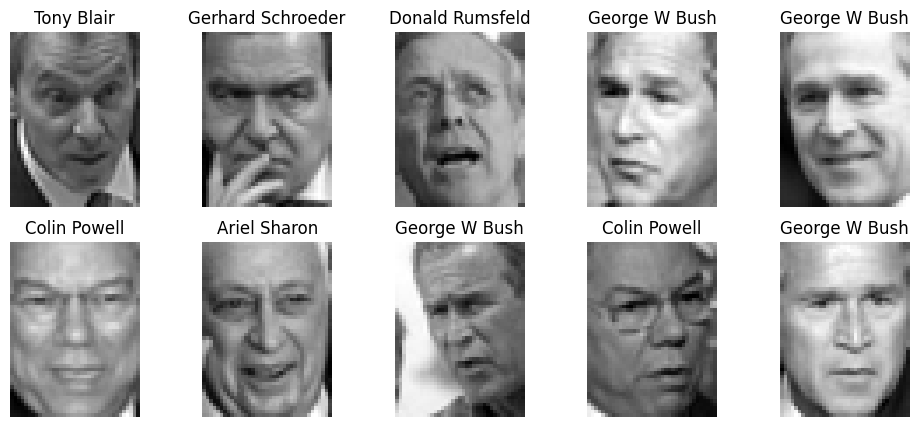

In [9]:
fig, axes = plt.subplots(2, 5, figsize=(12, 5))

for ax, image, label in zip(axes.ravel(), X, y):
    ax.imshow(image.reshape(lfw.images[0].shape), cmap="gray")
    ax.set_title(target_names[label])
    ax.axis("off")

plt.show()

In [10]:
## Prétraitement

#Les images ont une dimension élevée.
#J’applique :
#- une **standardisation**,
#- une **réduction de dimension par PCA**
#afin de réduire le coût de calcul et le sur-apprentissage.

In [11]:
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp
)

print("Train :", X_train.shape)
print("Validation :", X_val.shape)
print("Test :", X_test.shape)

Train : (936, 1850)
Validation : (312, 1850)
Test : (312, 1850)


In [12]:
## Modèle Baseline

#Comme baseline, j’utilise une **régression logistique**
#avec des paramètres par défaut.

In [13]:
baseline_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("pca", PCA(n_components=150, random_state=42)),
    ("clf", LogisticRegression(max_iter=1000))
])

baseline_pipeline.fit(X_train, y_train)

y_pred_baseline = baseline_pipeline.predict(X_test)

print("Accuracy baseline :", accuracy_score(y_test, y_pred_baseline))
print("F1-score baseline :", f1_score(y_test, y_pred_baseline, average="weighted"))

Accuracy baseline : 0.7692307692307693
F1-score baseline : 0.7668599516676631


In [14]:
## Recherche d’hyperparamètres

#J’utilise GridSearchCV afin d’optimiser la baseline
#et d’améliorer ses performances.

In [15]:
param_grid = {
    "pca__n_components": [100, 150],
    "clf__C": [0.1, 1, 10]
}

grid = GridSearchCV(
    baseline_pipeline,
    param_grid,
    cv=5,
    scoring="f1_weighted",
    n_jobs=-1
)

grid.fit(X_train, y_train)

print("Meilleurs paramètres :", grid.best_params_)
print("Meilleur score CV :", grid.best_score_)

best_baseline = grid.best_estimator_

Meilleurs paramètres : {'clf__C': 0.1, 'pca__n_components': 150}
Meilleur score CV : 0.7771313471811242


In [16]:
## Voting Classifier

#Je combine trois modèles complémentaires :
#- Régression Logistique
#- SVM
#- Random Forest

#Le **soft voting** est utilisé pour moyenner les probabilités.

In [17]:
voting_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("pca", PCA(n_components=150, random_state=42)),
    ("voting", VotingClassifier(
        estimators=[
            ("lr", LogisticRegression(max_iter=1000)),
            ("svm", SVC(probability=True)),
            ("rf", RandomForestClassifier(random_state=42))
        ],
        voting="soft"
    ))
])

voting_pipeline.fit(X_train, y_train)

y_pred_voting = voting_pipeline.predict(X_test)

print("Accuracy Voting :", accuracy_score(y_test, y_pred_voting))
print("F1-score Voting :", f1_score(y_test, y_pred_voting, average="weighted"))


Accuracy Voting : 0.7788461538461539
F1-score Voting : 0.7731120248786685


In [18]:
cv_scores = cross_val_score(
    voting_pipeline,
    X_train,
    y_train,
    cv=5,
    scoring="f1_weighted",
    n_jobs=-1
)

print("Scores CV :", cv_scores)
print("F1 moyen :", cv_scores.mean())
print("Écart-type :", cv_scores.std())

Scores CV : [0.74204734 0.80270887 0.79361182 0.77780548 0.78015325]
F1 moyen : 0.7792653493090689
Écart-type : 0.020705167293759843


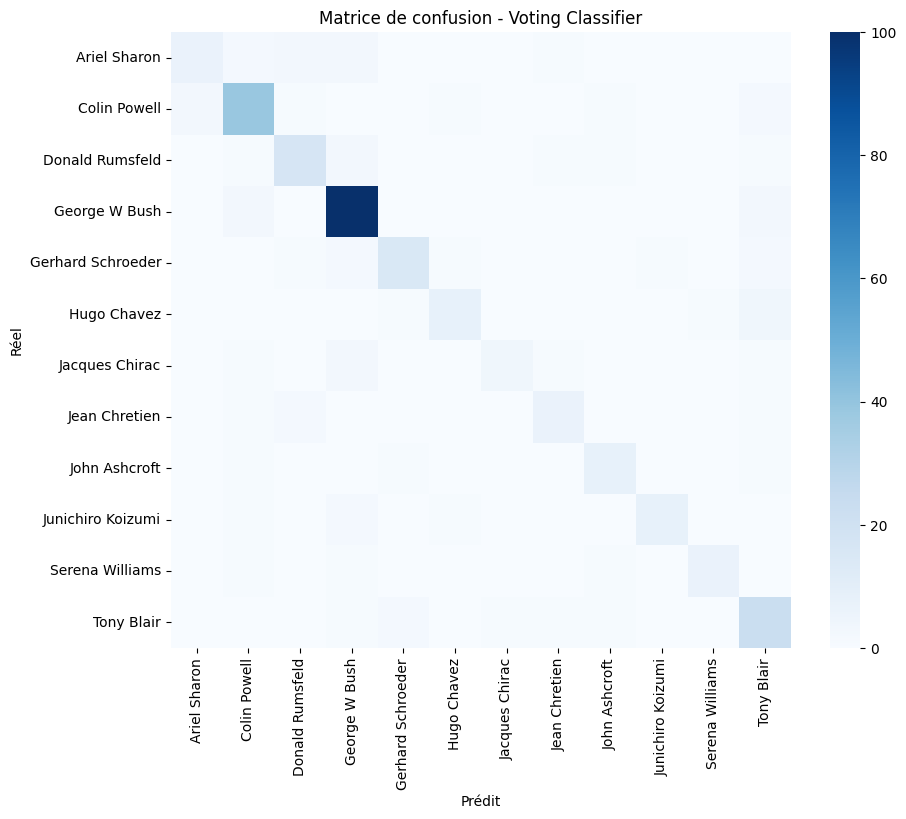

In [19]:
cm = confusion_matrix(y_test, y_pred_voting)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, cmap="Blues",
            xticklabels=target_names,
            yticklabels=target_names)
plt.xlabel("Prédit")
plt.ylabel("Réel")
plt.title("Matrice de confusion - Voting Classifier")
plt.show()

Nombre d'erreurs : 69


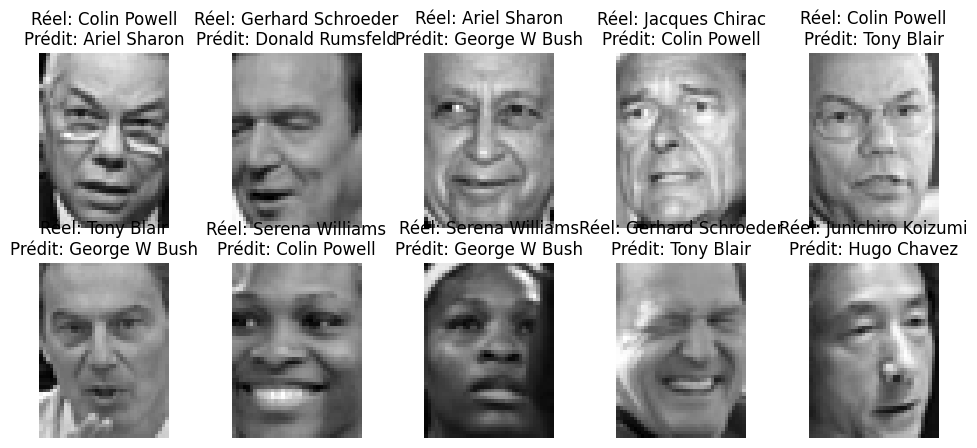

In [20]:
errors = np.where(y_test != y_pred_voting)[0]
print("Nombre d'erreurs :", len(errors))

fig, axes = plt.subplots(2, 5, figsize=(12, 5))
for ax, idx in zip(axes.ravel(), errors[:10]):
    ax.imshow(X_test[idx].reshape(lfw.images[0].shape), cmap="gray")
    ax.set_title(
        f"Réel: {target_names[y_test[idx]]}\nPrédit: {target_names[y_pred_voting[idx]]}"
    )
    ax.axis("off")

plt.show()

In [21]:
## Conclusion

#Le Voting Classifier améliore les performances par rapport à la baseline.
#La validation croisée confirme la robustesse des résultats.
#Ce travail respecte l’ensemble des étapes d’un pipeline
#de machine learning classique.